# Avaliação - Regressão usando MLP
## Inferir custos médicos do plano de saúde a partir do arquivo insurance.csv

### Carregamento dos dados

In [208]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot

In [209]:
insurance = pd.read_csv(Path('insurance.csv'))
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [210]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Visualizando os dados

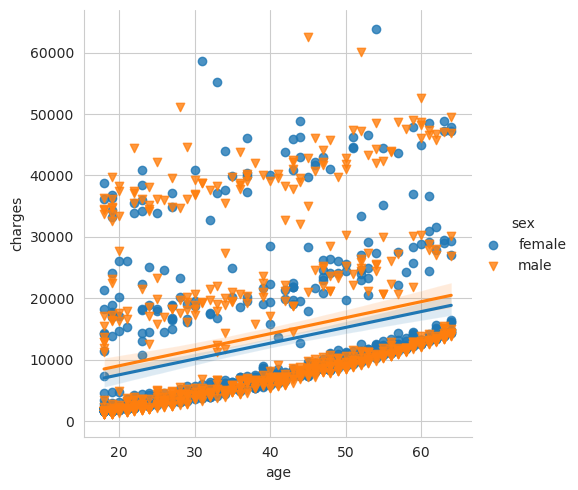

In [211]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.set_style('whitegrid')
sns.lmplot(x ='age', y ='charges', data = insurance, hue ='sex', markers =['o', 'v'])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


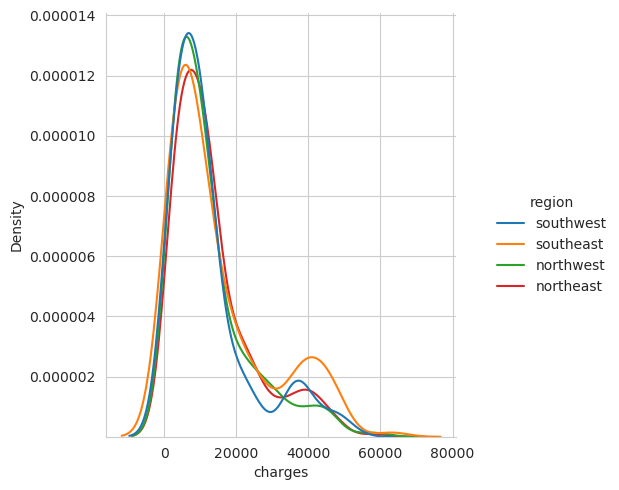

In [212]:
sns.displot(x='charges', data=insurance, hue='region', kind='kde')

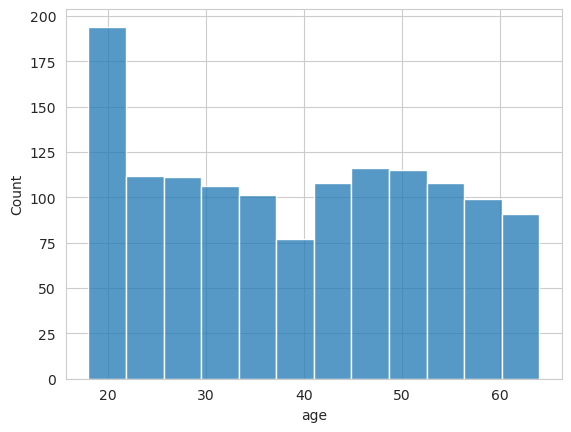

In [213]:
sns.histplot(insurance['age'])

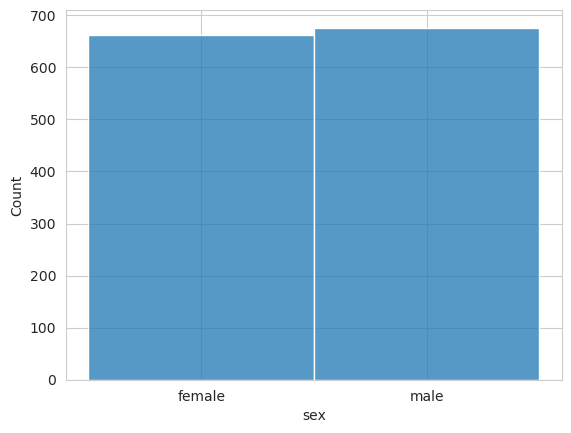

In [214]:
sns.histplot(insurance['sex'])

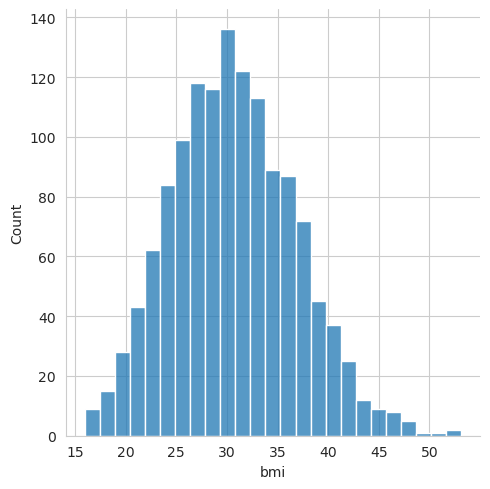

In [215]:
sns.displot(insurance['bmi'])

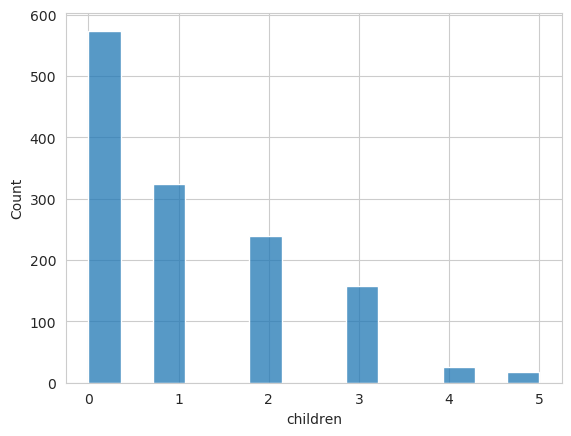

In [216]:
sns.histplot(insurance['children'])

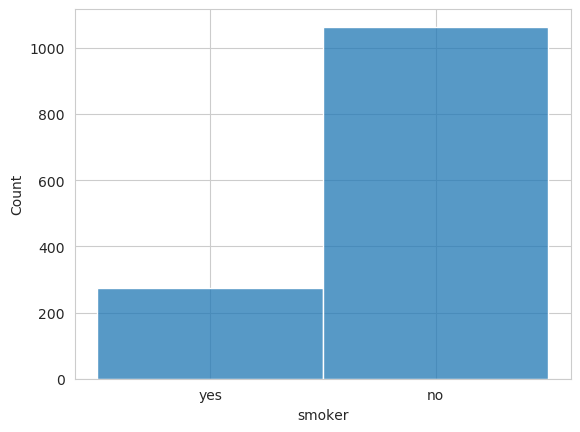

In [217]:
sns.histplot(insurance['smoker'])

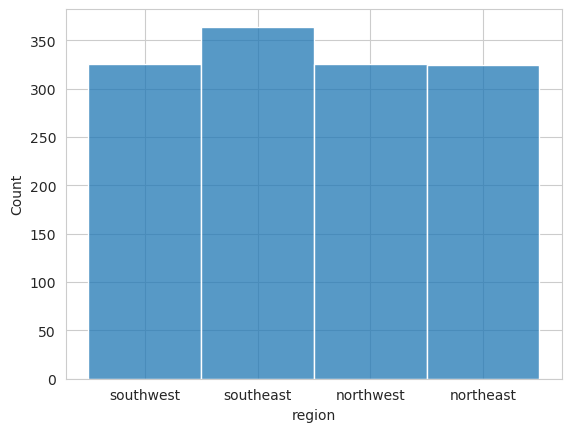

In [218]:
sns.histplot(insurance['region'])

In [219]:
#normalizar os valores, por exemplo min-max (0-1) para tirar os valores negativos
#transformer = MaxAbsScaler().fit(insurance['charges'].values.reshape(-1,1))
#transformer = transformer.transform(insurance['charges'].values.reshape(-1,1))
#insurance['charges'] = transformer.reshape(-1)
#sns.displot(insurance['charges'], kind = 'kde')

### Preparação dos dados

In [220]:
#função para reverter o pandas.get_dummies()
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [221]:
one_hot_encoding = pd.get_dummies(insurance[['sex', 'region', 'smoker']])
one_hot_encoding.head()

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,1,0,0,0,0,1,0,1
1,0,1,0,0,1,0,1,0
2,0,1,0,0,1,0,1,0
3,0,1,0,1,0,0,1,0
4,0,1,0,1,0,0,1,0


In [222]:
insurance = insurance.drop(['sex', 'region', 'smoker'], axis = 1)

In [223]:
insurance = pd.concat([insurance, one_hot_encoding], axis=1)
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   region_northeast  1338 non-null   uint8  
 7   region_northwest  1338 non-null   uint8  
 8   region_southeast  1338 non-null   uint8  
 9   region_southwest  1338 non-null   uint8  
 10  smoker_no         1338 non-null   uint8  
 11  smoker_yes        1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB


In [224]:
insurance.corr()['charges'].sort_values()

smoker_no          -0.787251
sex_female         -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
sex_male            0.057292
children            0.067998
region_southeast    0.073982
bmi                 0.198341
age                 0.299008
smoker_yes          0.787251
charges             1.000000
Name: charges, dtype: float64

In [225]:
train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

1070 train + 268 test


In [226]:
y_train, y_test = train_set['charges'], test_set['charges']

In [227]:
x_train, x_test = train_set.drop(['charges'], axis=1), test_set.drop(['charges'], axis=1)
x_train.head()

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
560,46,19.95,2,1,0,0,1,0,0,1,0
1285,47,24.32,0,1,0,1,0,0,0,1,0
1142,52,24.86,0,1,0,0,0,1,0,1,0
969,39,34.32,5,1,0,0,0,1,0,1,0
486,54,21.47,3,1,0,0,1,0,0,1,0


### Treinamento e avaliação

### Rede Neural com TensorFlow e Keras

In [228]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
#keras.layers.Flatten(input_shape=[11]), #x_train.shape
#keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42), input_shape=[11]),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation="relu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
#keras.layers.BatchNormalization(),
keras.layers.Dense(1)
])

#model = keras.models.Sequential([
#    keras.layers.Dense(50),
#    keras.layers.Dropout(0.25),
#    keras.layers.Dense(10),
#    keras.layers.Dropout(0.25),
#    keras.layers.Dense(1)
#])

#model.summary()

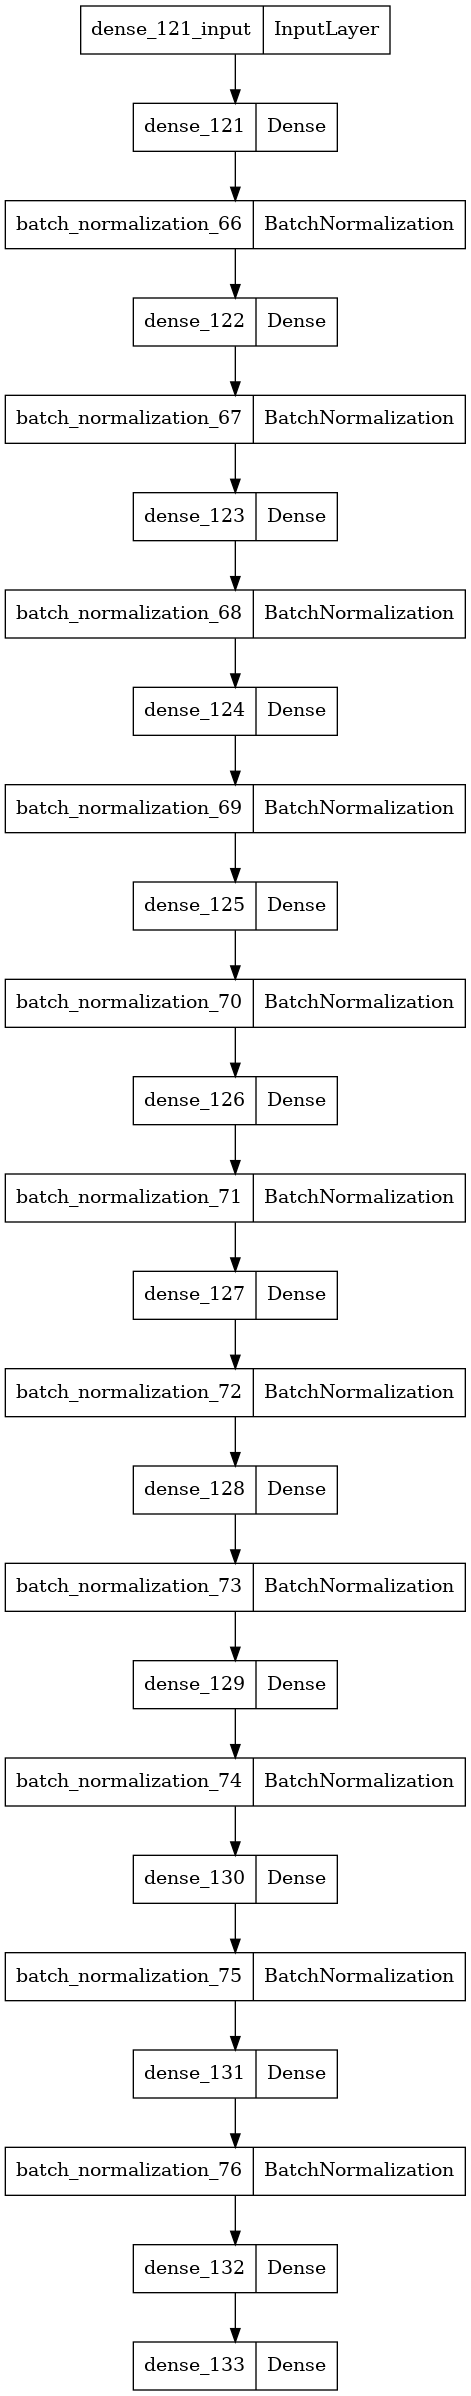

In [229]:
keras.utils.plot_model(model, to_file = "model.png")

In [230]:
#Depois de construir o modelo preciso compilar
#Na fase de compilação, define-se, por exemplo
#a função de perda, o otimizador, as métricas para serem calculadas  durante o treinamento e validação e etc

model.compile(loss="mae",
optimizer="adam")

In [231]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test),
callbacks=[keras.callbacks.EarlyStopping(patience=25)])

Epoch 1/500
34/34 [==============================] - 4s 19ms/step - loss: 13345.5303 - val_loss: 12967.5107
Epoch 2/500
34/34 [==============================] - 0s 6ms/step - loss: 13344.4404 - val_loss: 12966.8232
Epoch 3/500
34/34 [==============================] - 0s 6ms/step - loss: 13342.9453 - val_loss: 12965.8184
Epoch 4/500
34/34 [==============================] - 0s 6ms/step - loss: 13340.8457 - val_loss: 12963.8281
Epoch 5/500
34/34 [==============================] - 0s 6ms/step - loss: 13337.8682 - val_loss: 12960.0322
Epoch 6/500
34/34 [==============================] - 0s 6ms/step - loss: 13334.1152 - val_loss: 12955.3340
Epoch 7/500
34/34 [==============================] - 0s 6ms/step - loss: 13329.8008 - val_loss: 12950.1445
Epoch 8/500
34/34 [==============================] - 0s 6ms/step - loss: 13324.7930 - val_loss: 12941.1562
Epoch 9/500
34/34 [==============================] - 0s 5ms/step - loss: 13318.7705 - val_loss: 12935.0781
Epoch 10/500
34/34 [================

In [232]:
resultado_mlp2 = model.predict(x_test)

print('MSE, MAE E R2 COM MLP')
print(mean_squared_error(y_test, resultado_mlp2))
print(mean_absolute_error(y_test, resultado_mlp2))
print(r2_score(y_test, resultado_mlp2))

9/9 [==============================] - 0s 2ms/step
MSE, MAE E R2 COM MLP
19338348.887105435
2035.0301609057108
0.8754363484887465


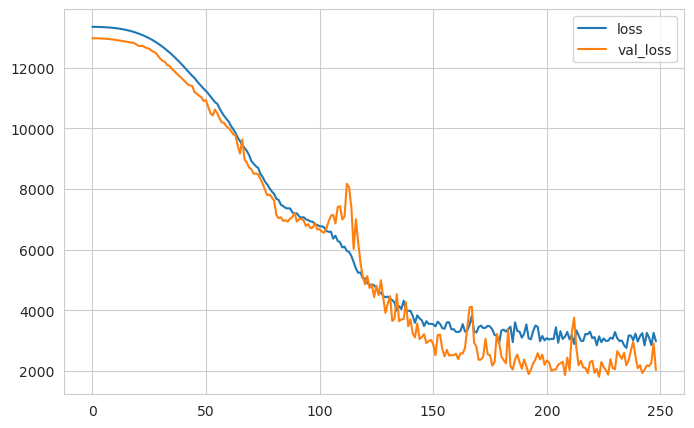

In [233]:
#Posso fazer curvas de aprendizado com o histórico do treinamento da rede neural
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

In [234]:
def build_model(n_hidden=12, n_neurons=12, learning_rate=3e-3, input_shape=[11], optimizer = "nadam"):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate, momentum=0.9, nesterov=True)
    model.compile(loss="mse", optimizer=optimizer)
    return model


In [235]:
from scikeras.wrappers import KerasRegressor

#keras_reg = KerasRegressor(build_model, n_hidden=12, n_neurons=12, learning_rate=3e-3, input_shape=[11])
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
#history = keras_reg.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))

/tmp/ipykernel_22427/4210872570.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [236]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_distribs = {
"n_hidden": np.arange(1, 15),
"n_neurons": np.arange(1, 15),
"optimizer": ["Adagrad", "RMSprop", "Adam", "Nadam", "Adamax"],
#"learning_rate": reciprocal(3e-4, 3e-2),
#"learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
#"learning_rate": [0.001, 0.01, 0.1],
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=30, cv=3, n_jobs=-1, scoring="r2")
rnd_search_cv.fit(x_train, y_train, epochs=300,
validation_data=(x_test, y_test),   
callbacks=[keras.callbacks.EarlyStopping(patience=20, verbose=0)], verbose=0)

2022-12-04 02:11:44.201679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 02:11:44.323660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 02:11:44.389160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

12/12 [==============================] - 0s 1ms/step


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd174788a30>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'n_hidden': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'optimizer': ['Adagrad', 'RMSprop',
                                                      'Adam', 'Nadam',
                                                      'Adamax']},
                   scoring='r2')

In [237]:
rnd_search_cv.best_params_

{'optimizer': 'Adam', 'n_neurons': 13, 'n_hidden': 10}

In [238]:
rnd_search_cv.best_score_

0.8202235291128871

In [239]:
model = rnd_search_cv.best_estimator_.model

In [240]:
resultado_mlp2 = model.predict(x_test)

print('MSE, MAE E R2 COM MLP')
print(mean_squared_error(y_test, resultado_mlp2))
print(mean_absolute_error(y_test, resultado_mlp2))
print(r2_score(y_test, resultado_mlp2))

9/9 [==============================] - 0s 2ms/step
MSE, MAE E R2 COM MLP
20402505.919024497
2874.8914594215544
0.8685818188465804
